<div style="text-align:center">
    <img src="cs-logo.png" alt="CS Logo" height="100">
</div>

# Community detection & Influence Maximization with Graphs

Prepared by: Ali Abusaleh, Mir Wise Khan


Source: https://github.com/aliabusaleh/CS-community-detection

## The dataset

https://snap.stanford.edu/data/email-Eu-core.html

The network was generated using email data from a large European research institution. We have anonymized information about all incoming and outgoing email between members of the research institution. There is an edge (u, v) in the network if person u sent person v at least one email. The e-mails only represent communication between institution members (the core), and the dataset does not contain incoming messages from or outgoing messages to the rest of the world.

The dataset also contains "ground-truth" community memberships of the nodes. Each individual belongs to exactly one of 42 departments at the research institute.


## Contents of the notebook
1. Loading the dataset
2. Preprocessing the dataset
3. Community detection with Louvain
4. Interactive plot of Louvain (https://mirwise.com/projects/mgma/leiden.html)
5. Community detection with Leiden
6. Interactive plot of Leiden (https://mirwise.com/projects/mgma/leiden.html)
7. Comparison between Louvain and Leiden
8. Evaluation with Metrics (Modularity, Density, Cut Ratio and Normalized Cut) 
9. Silhouette Analysis of Louvain and Leiden
10. Embedding with Node2Vec
11. Machine Learning based Clustering (K-means)
12. Silhouette Analysis with K-means
13. Comparison of classical approach (Louvain) with ML (k-means)
14. Influence Maximization
15. Influence Maximization with animation of diffusion


In [81]:
# !pip install python-louvain pygraphviz
# !pip install leidenalg
# !pip install node2vec

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.2/24.0 MB 6.9 MB/s eta 0:00:04
    --------------------------------------- 0.5/24.0 MB 7.0 MB/s eta 0:00:04
    --------------------------------------- 0.6/24.0 MB 5.3 MB/s eta 0:00:05
   - -------------------------------------- 0.7/24.0 MB 4.4 MB/s eta 0:00:06
   - -------------------------------------- 0.7/24.0 MB 4.2 MB/s eta 0:00:06
   - -------------------------------------- 0.9/24.0 MB 3.7 MB/s eta 0:00:07
   - -------------------------------------- 1.0/24.0 MB 3.8 MB/s eta 0:00:07
   - -------------------------------------- 1.1/24.0 MB 3.3 MB/s eta 0:00:07
   -- ------------------------------------- 1.2/24.0 MB 3.3 MB/s eta 0:00:07
   -- ------------------------------------- 1.3/24.0 MB 3.2 MB/s eta 0:00:08
   -- ------------------------------------- 1.5/24.0 MB 3.1 MB/s eta 0:00:08
   -- ------------------------------------- 1.6/24.0 MB 3.1 MB/s eta 0:00:08
   -- 

In [21]:
# from pyspark import SparkContext
# from pyspark.sql import SparkSession
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

## Step 1: Load the Data

In [2]:
# Load email communications
emails_df = pd.read_csv('data/email-Eu-core.txt', sep=' ', header=None, names=['sender', 'receiver'])

# Load department labels
departments_df = pd.read_csv('data/email-Eu-core-department-labels.txt', sep=' ', header=None, names=['member', 'department'])
# Add department labels as node attributes
department_dict = departments_df.set_index('member')['department'].to_dict()

## Step 2: Build the graph

#### Filter the recursive nodes

In [3]:
emails_df = emails_df[emails_df['sender'] != emails_df['receiver']]
emails_df.head()

,sender,receiver
0,0,1
1,2,3
2,2,4
3,5,6
4,5,7


#### Let us test that graph is successfully built by a small sample `nodeId` [0-5]

In [4]:
filtered_emails_df = emails_df[(emails_df['sender'] >= 0) & (emails_df['sender'] <= 5) & (emails_df['receiver'] >= 0) & (emails_df['receiver'] <= 5)]
filtered_emails_df


,sender,receiver
0,0,1
1,2,3
2,2,4
138,4,2
139,4,3
1212,3,2
1838,3,4
3485,5,2
5183,2,5
14670,0,5


In [5]:
def build_graph_from_adjacency_list(adj_df, departments_df):
        
    G = nx.from_pandas_edgelist(adj_df, 'sender', 'receiver')
    nx.set_node_attributes(G, department_dict, 'department')

    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='grey', node_size=800, font_size=6, font_weight='bold', font_color='black', width=0.5, alpha=0.7)
    return G

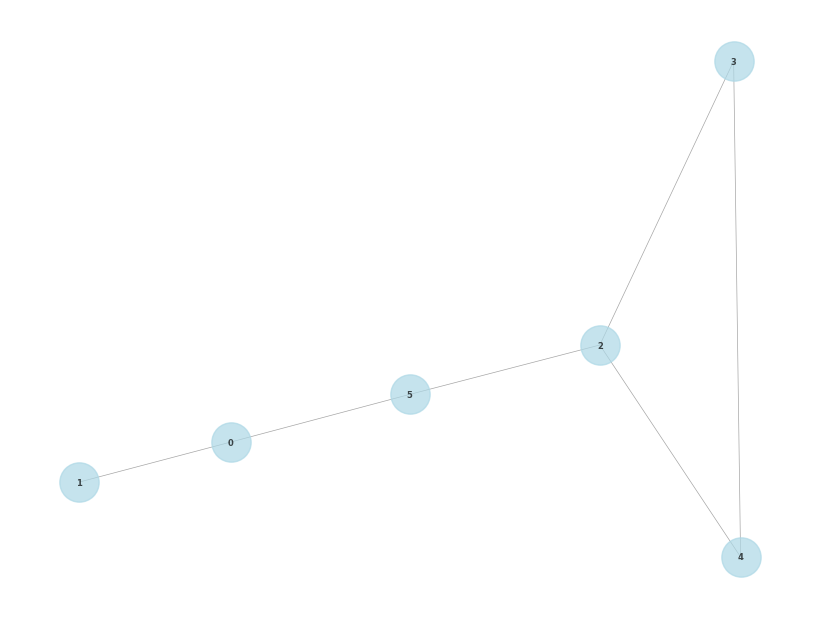

In [6]:
G = build_graph_from_adjacency_list(filtered_emails_df, departments_df)

### Now let us create full graph of the data

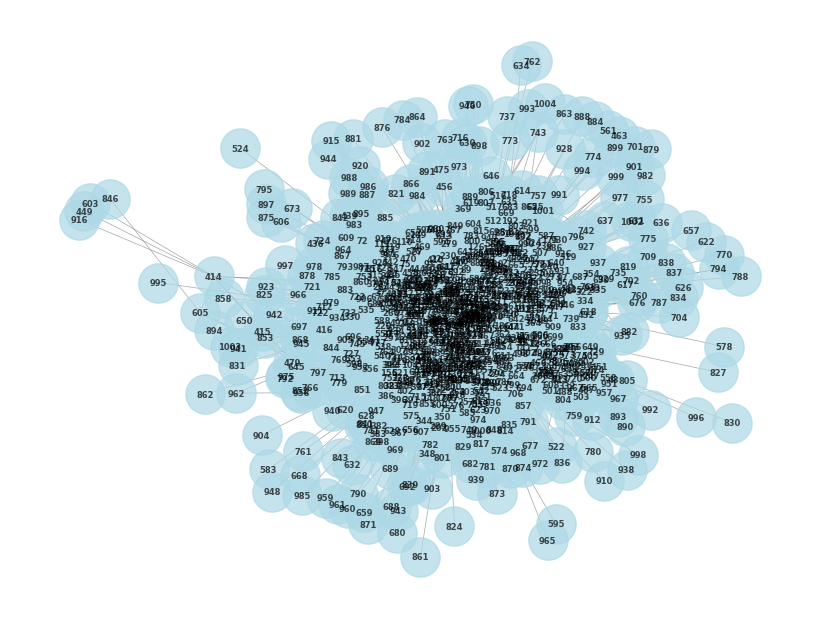

In [7]:
G = build_graph_from_adjacency_list(emails_df, departments_df)

### Let us plot the distribution of the departments

In [8]:
from collections import Counter

department_counts = Counter(department_dict.values())
print(department_counts)


Counter({4: 109, 14: 92, 1: 65, 21: 61, 15: 55, 7: 51, 0: 49, 10: 39, 17: 35, 9: 32, 11: 29, 19: 29, 6: 28, 23: 27, 13: 26, 22: 25, 16: 25, 36: 22, 8: 19, 5: 18, 37: 15, 20: 14, 34: 13, 38: 13, 35: 13, 3: 12, 27: 10, 2: 10, 26: 9, 32: 9, 28: 8, 31: 8, 25: 6, 24: 6, 29: 5, 40: 4, 30: 4, 39: 3, 12: 3, 41: 2, 18: 1, 33: 1})


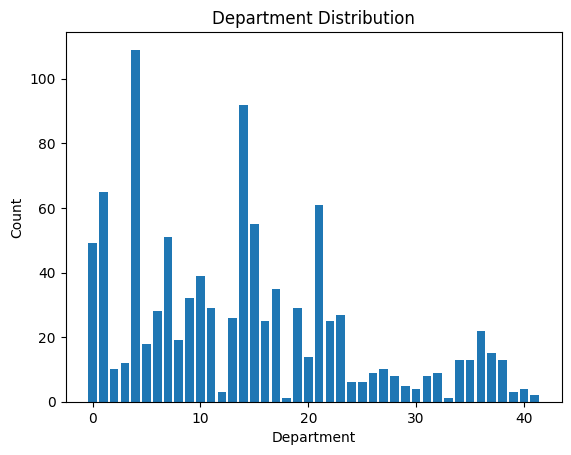

In [9]:
plt.bar(department_counts.keys(), department_counts.values())
plt.xlabel('Department')
plt.ylabel('Count')
plt.title('Department Distribution')
plt.show()


To retrieve the department of associated node

In [10]:
nodeId = 2
department = G.nodes[nodeId]['department']
print(f"The department of node {nodeId} is {department}")


The department of node 2 is 21


## Step 4: Extract the Adjacency Matrix

*Notice:* The data is inclusive of recursive nodes

In [11]:
adjacency_matrix = nx.adjacency_matrix(G)

# Convert the adjacency matrix to a dense format for display purposes
adjacency_matrix_dense = adjacency_matrix.todense()

# Display the adjacency matrix as a DataFrame for better readability
df_adjacency_matrix = pd.DataFrame(adjacency_matrix_dense, index=G.nodes(), columns=G.nodes())
df_adjacency_matrix

C:\Users\Mirwi\AppData\Local\Temp\ipykernel_42768\1264560264.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)


,0,1,2,3,4,5,6,7,8,9,...,996,997,763,998,999,1000,1001,1002,1003,1004
0,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,0,0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Louvain Algorithm

## Introduction
The Louvain algorithm is a community detection algorithm designed for large networks. It aims to maximize the modularity score for each community, evaluating how densely connected nodes are within a community compared to random networks. More information on the Louvain method can be found [here](https://en.wikipedia.org/wiki/Louvain_method).

## Library
Community detection will be performed using the [community](https://python-louvain.readthedocs.io/en/latest/api.html) library in conjunction with NetworkX.

## Steps

### Finding Communities
In this phase, the algorithm follows these steps:
1. **Initialization**: Each node is initially assigned to its own community.
2. **Modularity Optimization**: For each node, the algorithm seeks the maximum positive modularity gain by exploring potential moves to all neighbor communities. If no positive gain is achieved, the node remains in its original community.
######  **Assign final results**: finally we will assign each node it's community as an attribute to be used later
### Displaying the Results
This section showcases the community results in two ways:

- **Static Display**: All nodes are visualized in a single image, with each community represented by a distinct color.
- **Interactive Display**: Utilizing the *pyvis* library, an interactive page is generated to display the top-10 nodes within each community.

For more detailed information, please refer to the code documentation.


In [12]:
node_order = list(G.nodes())

#### Finding Communities

In [13]:
# louvain community detection
from community import community_louvain
louvain_partition = community_louvain.best_partition(G)
# Add the partition as a node attribute
nx.set_node_attributes(G, louvain_partition, 'louvain_community')
# show the number of communities
num_communities = len(set(louvain_partition.values()))
print(f"The number of communities detected is {num_communities}")


The number of communities detected is 7


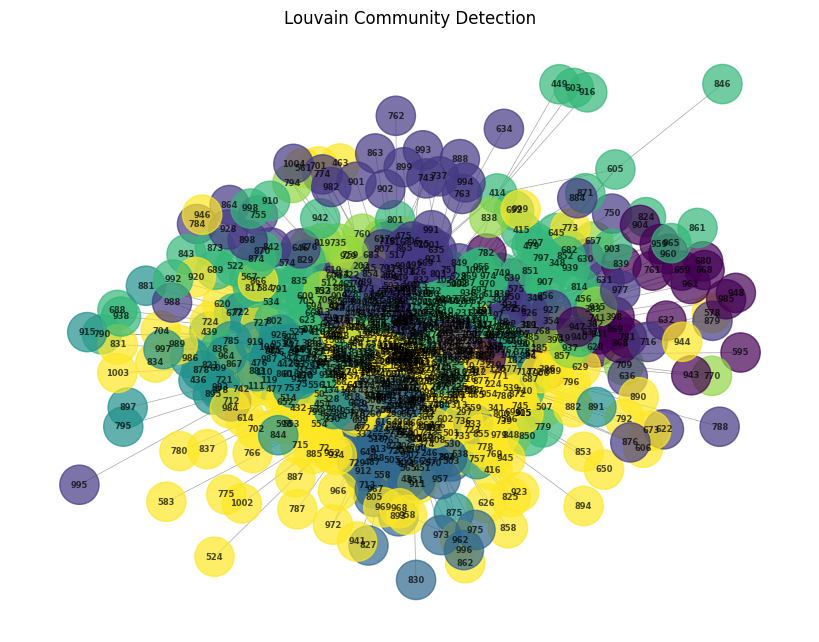

In [14]:
# Create a list of colors for the nodes based on their community
colors = [louvain_partition[n] for n in G.nodes()]
# Draw the graph with the colors
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=colors, edge_color='grey', node_size=800, font_size=6, font_weight='bold', font_color='black', width=0.5, alpha=0.7)
plt.title('Louvain Community Detection')
plt.show()

#### Interactive Visalization for the Graph
To visualize the graphs more clearly we only display top $25$ nodes from each community and we generat an html file and that is being hosted at the URL https://mirwise.com/projects/mgma/louvain.html .


In [ ]:
# # provide zoomable graph for better visualization
# from pyvis.network import Network

# net = Network(notebook=True)
# # get top 10 nodes for each community
# top_nodes = {community: [] for community in set(louvain_partition.values())}
# for node, community in louvain_partition.items():
#     if len(top_nodes[community]) < 25:
#         top_nodes[community].append(node)
# # add the nodes and edges to the network with colors
# for community, nodes in top_nodes.items():
#     for node in nodes:
#         net.add_node(node, label=node)
#     for sender, receiver in G.edges():
#         if sender in nodes and receiver in nodes:
#             net.add_edge(sender, receiver)
# # build a color map for the nodes based on their community with hex colors
# color_map = {community: f"#{np.random.choice(range(256**3)):06x}" for community in set(louvain_partition.values())}
# # for each node in the network, add the color and size to the node
# for node in net.nodes:
#     node['color'] = color_map.get(colors[node['id']])
#     node['size'] = 10

# # show the network
# net.show("louvain2.html")

In [61]:
# make a table for the top_nodes with it's communities 
# show node_id, community, department
top_nodes_df = pd.DataFrame(columns=['node_id', 'community', 'department'])
for community, nodes in top_nodes.items():
    for node in nodes:
        top_nodes_df = pd.concat([top_nodes_df, pd.DataFrame({'node_id': node, 'community': community, 'department': G.nodes[node]['department']}, index=[0])], ignore_index=True)
top_nodes_df

,node_id,community,department
0,0,0,1
1,1,0,1
2,10,0,9
3,17,0,1
4,18,0,1
...,...,...,...
75,110,7,8
76,111,7,8
77,112,7,8
78,143,7,8


In [62]:
# show number of communities, number of departments, number of nodes
num_communities = len(set(louvain_partition.values()))
num_departments = len(set(department_dict.values()))
num_nodes = len(G.nodes())
print(f"The number of communities detected is {num_communities}")
print(f"The number of departments is {num_departments}")
print(f"The number of nodes is {num_nodes}")

The number of communities detected is 8
The number of departments is 42
The number of nodes is 986


In [63]:
# show the department for each community
community_departments = {community: [] for community in set(louvain_partition.values())}
for node, community in louvain_partition.items():
    if G.nodes[node]['department'] not in community_departments[community]:
        community_departments[community].append(G.nodes[node]['department'])
# show the department for each community pretty
for community, departments in community_departments.items():
    print(f"Community {community} has departments {departments}")

# show for each community the node's id
community_nodes = {community: [] for community in set(louvain_partition.values())}
for node, community in louvain_partition.items():
    community_nodes[community].append(node)
# show for each community the node's id
for community, nodes in community_nodes.items():
    print(f"Community {community} has nodes {nodes}")
    

Community 0 has departments [1, 9, 34, 36, 37, 15, 3, 29, 38, 6, 26, 40, 35, 23, 27, 24, 14, 31, 4, 39, 30, 21, 22, 41, 7]
Community 1 has departments [7, 0, 36, 1, 15, 13, 23, 6, 24, 5, 21, 4]
Community 2 has departments [14, 15, 32, 9]
Community 3 has departments [26, 11, 10, 3, 4, 20, 13, 2, 12, 22, 6, 36, 9, 18, 31]
Community 4 has departments [4, 5, 25, 0, 3, 26, 20, 33, 15, 6, 14]
Community 5 has departments [17, 34, 36, 16, 23, 38, 4, 27, 10, 21, 6]
Community 6 has departments [21, 25, 22, 20, 38, 28, 19, 32, 36, 1, 6, 24, 16, 17, 30, 4, 29, 34]
Community 7 has departments [8, 15, 27, 22, 31, 35, 6]
Community 0 has nodes [0, 1, 10, 17, 18, 20, 21, 22, 42, 49, 50, 67, 68, 69, 70, 71, 72, 73, 74, 77, 80, 81, 82, 83, 84, 85, 86, 87, 92, 105, 106, 117, 118, 120, 121, 127, 142, 144, 145, 146, 147, 152, 153, 154, 155, 162, 163, 166, 173, 177, 186, 187, 188, 189, 190, 212, 215, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 248, 249, 253, 254, 255, 256, 259, 260, 268,

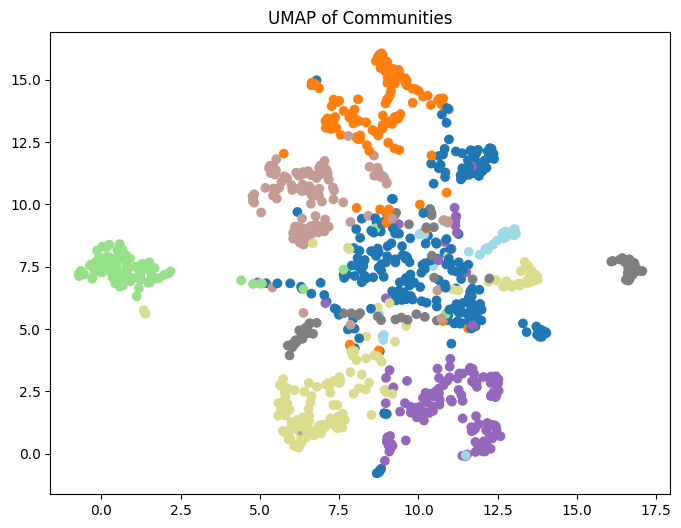

In [64]:
# get adjacency matrix for the communities
community_adjacency_matrix = nx.adjacency_matrix(G)
# Convert the adjacency matrix to a dense format for display purposes
community_adjacency_matrix_dense = np.asarray(community_adjacency_matrix.todense())
# build a umap for the communities and plot it
import umap
embedding = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(community_adjacency_matrix_dense)
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='tab20')
plt.title('UMAP of Communities')
plt.show()

# Leiden algorithm

The Leiden algorithm is an algorithm for detecting communities in large networks. The algorithm separates nodes into disjoint communities so as to maximize a modularity score for each community. Modularity quantifies the quality of an assignment of nodes to communities, that is how densely connected nodes in a community are, compared to how connected they would be in a random network.

The Leiden algorithm is a hierarchical clustering algorithm, that recursively merges communities into single nodes by greedily optimizing the modularity and the process repeats in the condensed graph. It modifies the Louvain algorithm to address some of its shortcomings, namely the case where some of the communities found by Louvain are not well-connected. This is achieved by periodically randomly breaking down communities into smaller well-connected ones.

In [23]:
import leidenalg
import igraph as ig

In [27]:
# Convert NetworkX graph to igraph graph for Leiden algorithm
ig_graph = ig.Graph.TupleList(G.edges())
leiden_partition = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition, n_iterations=-1)
# show the number of communities in leiden
num_communities_leiden = len(leiden_partition)
print(f"The number of communities detected using Leiden is {num_communities_leiden}")
# Add the louvain_partition as a node attribute
nx.set_node_attributes(G, leiden_partition.membership, 'leiden_community')
# Prepare data for silhouette analysis
leiden_labels = np.array([G.nodes[node]['leiden_community'] for node in node_order])


The number of communities detected using Leiden is 7


In [28]:
community_departments_leiden = {community: [] for community in range(len(leiden_partition))}
for community in range(len(leiden_partition)):
    for node in leiden_partition.subgraphs()[community].vs['name']:
        if G.nodes[node]['department'] not in community_departments_leiden[community]:
            community_departments_leiden[community].append(G.nodes[node]['department'])
# show the department for each community pretty
for community, departments in community_departments_leiden.items():
    print(f"Community {community} has departments {departments}")

# show for community the node id's 
top_nodes_leiden = {community: [] for community in range(len(leiden_partition))}
for community in range(len(leiden_partition)):
    for node in leiden_partition.subgraphs()[community].vs['name']:
        top_nodes_leiden[community].append(node)
# show the top nodes for each community pretty
for community, nodes in top_nodes_leiden.items():
    print(f"Community {community} has nodes {nodes}")

    
    

Community 0 has departments [1, 15, 39, 31, 36, 23, 38, 9, 40, 35, 6, 37, 34, 25, 14, 26, 4, 8, 22, 30, 24, 29, 27, 41, 3, 7, 10, 17, 21]
Community 1 has departments [20, 25, 19, 21, 38, 22, 32, 1, 28, 36, 4, 29, 34, 6, 17, 16, 24, 30]
Community 2 has departments [3, 25, 4, 5, 36, 0, 8, 21, 33, 14, 6, 26, 15]
Community 3 has departments [1, 0, 7, 36, 23, 15, 27, 3, 6, 26, 21, 13, 24, 5, 4]
Community 4 has departments [6, 26, 10, 20, 13, 11, 22, 2, 12, 3, 9, 18, 4, 38, 31]
Community 5 has departments [14, 6, 32, 35, 20, 15, 4, 9]
Community 6 has departments [16, 17]
Community 0 has nodes [0, 1, 17, 316, 146, 268, 221, 218, 18, 459, 215, 73, 74, 248, 226, 560, 309, 297, 313, 223, 222, 283, 166, 120, 495, 549, 310, 147, 106, 21, 225, 82, 254, 155, 85, 189, 726, 224, 255, 187, 127, 121, 84, 537, 641, 979, 317, 142, 434, 162, 300, 489, 612, 249, 107, 494, 62, 546, 651, 896, 405, 256, 81, 932, 473, 282, 424, 431, 145, 329, 117, 327, 105, 357, 279, 669, 42, 312, 306, 492, 828, 469, 375, 184, 

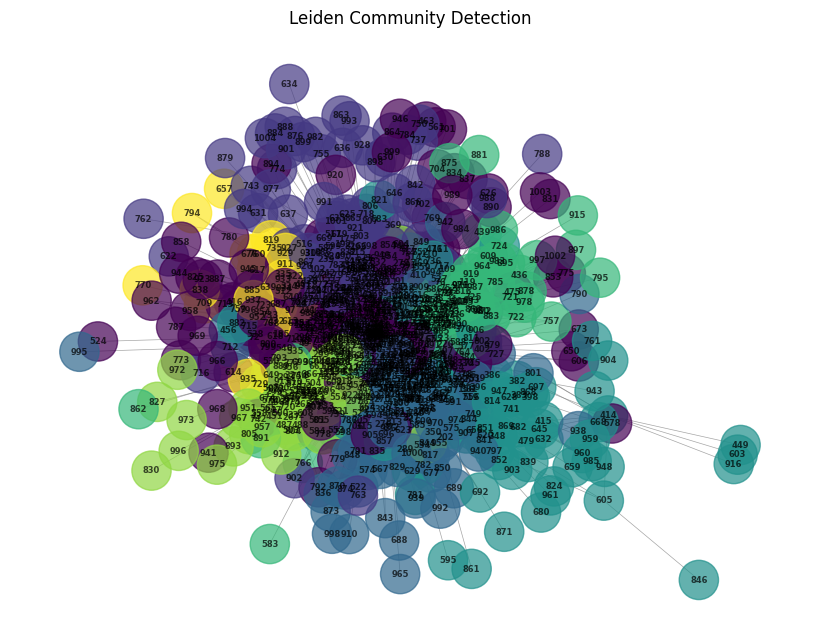

In [29]:
# Create a list of colors for the nodes based on their community
colors_leiden =  []
for node in G.nodes():
    for community in range(len(leiden_partition)):
        if node in leiden_partition.subgraphs()[community].vs['name']:
            colors_leiden.append(community)
            break
# Draw the graph with the colors
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=colors_leiden, edge_color='grey', node_size=800, font_size=6, font_weight='bold', font_color='black', width=0.5, alpha=0.7)
plt.title('Leiden Community Detection')
plt.show()


#### Interactive Visalization for the Graph
To visualize the graphs more clearly we only display top $25$ nodes from each community and we generat an html file and that is being hosted at the URL https://mirwise.com/projects/mgma/leiden.html. No need to run the following commented code as the results are live. 


In [ ]:
# net = Network(notebook=True)
# # get top 10 nodes for each community
# top_nodes = {community: items[:25] for community, items in enumerate(leiden_partition)}
# # add the nodes and edges to the network with colors
# for community, nodes in top_nodes.items():
#     for node in nodes:
#         net.add_node(node, label=node)
#     for sender, receiver in G.edges():
#         if sender in nodes and receiver in nodes:
#             net.add_edge(sender, receiver)
# # build a color map for the nodes based on their community with hex colors
# color_map = {community: f"#{np.random.choice(range(256**3)):06x}" for community, items in enumerate(leiden_partition)}
# # for each node in the network, add the color and size to the node
# for node in net.nodes:
#     node['color'] = color_map.get(colors[node['id']])
#     node['size'] = 10

# # show the network
# net.show("leiden.html")

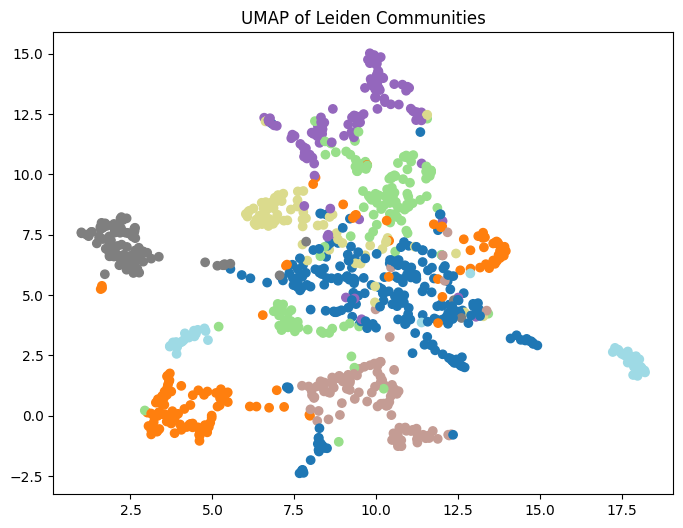

In [71]:
# get adjacency matrix for the leiden communities
community_adjacency_matrix_leiden = nx.adjacency_matrix(G)
# Convert the adjacency matrix to a dense format for display purposes
community_adjacency_matrix_dense_leiden = np.asarray(community_adjacency_matrix_leiden.todense())
# make umap for the leiden communities
embedding_leiden = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(community_adjacency_matrix_dense_leiden)
plt.figure(figsize=(8, 6))
plt.scatter(embedding_leiden[:, 0], embedding_leiden[:, 1], c=colors_leiden, cmap='tab20')
plt.title('UMAP of Leiden Communities')
plt.show()


# Comparison between the algorithms 
###  make some statistics comperisons + visualization using umap

In [72]:
# compare the number of communities detected by Louvain, and Leiden
print(f"The number of communities detected using Louvain is {num_communities}")
print(f"The number of communities detected using Leiden is {num_communities_leiden}")
# extract the communities detected by Louvain and Leiden for comparison
louvain_communities = set(louvain_partition.values())
leiden_communities = set(ledian_partion.membership)
# show the number of communities detected by both algorithms
num_common_communities = len(louvain_communities.intersection(leiden_communities))
print(f"The number of communities detected by both Louvain and Leiden is {num_common_communities}")

# show the number of nodes in each community
louvain_community_sizes = Counter(louvain_partition.values())
leiden_community_sizes = Counter(ledian_partion.membership)
# show the number of nodes in each community pretty
for community, size in louvain_community_sizes.items():
    print(f"Louvain community {community} has {size} nodes")
for community, size in leiden_community_sizes.items():
    print(f"Leiden community {community} has {size} nodes")

# show the number of nodes in each community
louvain_community_sizes = Counter(louvain_partition.values())
leiden_community_sizes = Counter(ledian_partion.membership)
# show the number of nodes in each community pretty
for community, size in louvain_community_sizes.items():
    print(f"Louvain community {community} has {size} nodes")
for community, size in leiden_community_sizes.items():
    print(f"Leiden community {community} has {size} nodes")

# save the data for communities detected by Louvain and Leiden in a csv file
louvain_community_df = pd.DataFrame(louvain_community_sizes.items(), columns=['community', 'size'])
louvain_community_df['algorithm'] = 'Louvain'
leiden_community_df = pd.DataFrame(leiden_community_sizes.items(), columns=['community', 'size'])
leiden_community_df['algorithm'] = 'Leiden'
community_df = pd.concat([louvain_community_df, leiden_community_df])
community_df.to_csv('./data/communities.csv', index=False)



The number of communities detected using Louvain is 8
The number of communities detected using Leiden is 8
The number of communities detected by both Louvain and Leiden is 8
Louvain community 0 has 249 nodes
Louvain community 6 has 149 nodes
Louvain community 2 has 93 nodes
Louvain community 3 has 134 nodes
Louvain community 4 has 127 nodes
Louvain community 5 has 80 nodes
Louvain community 1 has 125 nodes
Louvain community 7 has 29 nodes
Leiden community 6 has 75 nodes
Leiden community 2 has 140 nodes
Leiden community 3 has 113 nodes
Leiden community 5 has 95 nodes
Leiden community 7 has 55 nodes
Leiden community 1 has 148 nodes
Leiden community 0 has 250 nodes
Leiden community 4 has 110 nodes
Louvain community 0 has 249 nodes
Louvain community 6 has 149 nodes
Louvain community 2 has 93 nodes
Louvain community 3 has 134 nodes
Louvain community 4 has 127 nodes
Louvain community 5 has 80 nodes
Louvain community 1 has 125 nodes
Louvain community 7 has 29 nodes
Leiden community 6 has 75 n

In [73]:
# show the difference in the number of communities detected by Louvain and Leiden
num_communities_difference = abs(num_communities - num_communities_leiden)
print(f"The difference in the number of communities detected by Louvain and Leiden is {num_communities_difference}")


The difference in the number of communities detected by Louvain and Leiden is 0


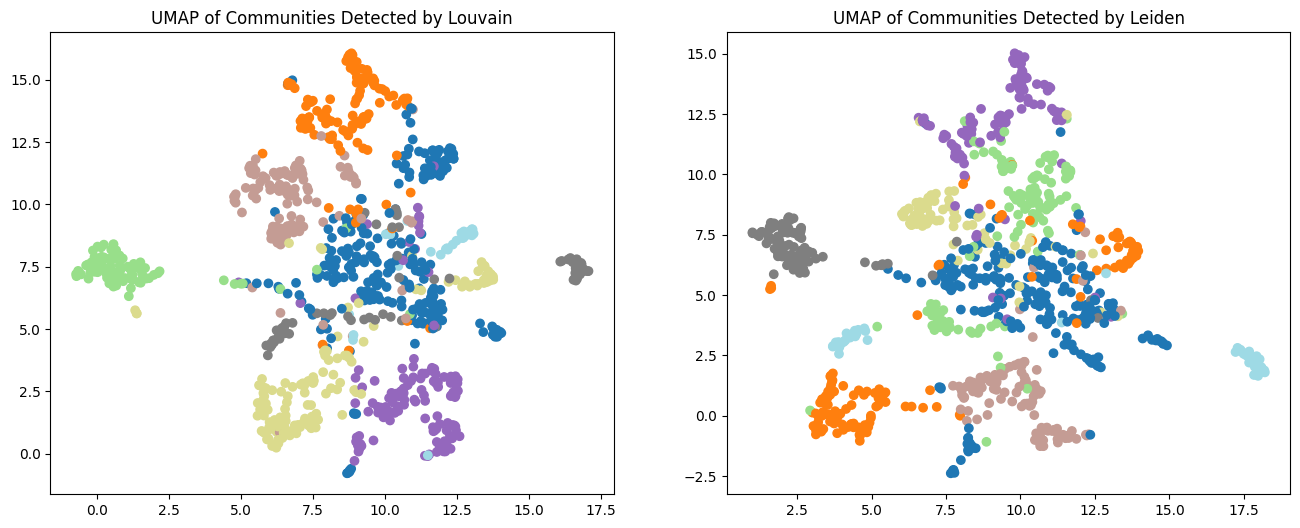

In [74]:
# draw 2 umap for the communities detected by Louvain and Leiden next to each other
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='tab20')
ax[0].set_title('UMAP of Communities Detected by Louvain')
ax[1].scatter(embedding_leiden[:, 0], embedding_leiden[:, 1], c=colors_leiden, cmap='tab20')
ax[1].set_title('UMAP of Communities Detected by Leiden')
plt.show()


####  Modularity by algorithms
It measures the extent to which the network can be divided into distinct communities based on the observed connectivity patterns, and it compares the number of edges within communities to the expected number of edges in a random network with the same node degrees. The value of modularity ranges from -1 to 1.


- A modularity close to 1 indicates a **strong community structure**, meaning the connections within communities are dense, and connections between communities are sparse.
- A modularity close to 0 suggests that the division of the network into communities is no better than a random assignment of nodes to communities.
- A negative modularity indicates that the density of links within communities is less than what would be expected in a corresponding random network model. This suggests that the proposed community structure is poorly defined, with fewer within-community links than would be expected by chance.

$$
Q = \frac{1}{2m} \sum_{ij} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)
$$


where:
- $Q$: Modularity, a measure of the quality of the partition into communities.

- $A_{ij}$: The entry in the adjacency matrix representing the connection between nodes $i$ and $j$.

- $k_i$ and $k_j$: The degrees (total number of edges) of nodes $i$ and $j$, respectively.

- $m$: The total number of edges in the network.

- $δ(c_i, c_j)$: Kronecker delta function, which equals $1$ if nodes $i$ and $j$ are in the same community $(c_i = c_j)$ and $0$ otherwise.

### Objective
The goal is to find a partition of nodes into communities that maximizes this modularity value, indicating a stronger community structure within the network.


In [75]:
# calculate the modularity for the communities detected by Louvain and Leiden
modularity_louvain = community_louvain.modularity(louvain_partition, G)
modularity_leiden = leidenalg.ModularityVertexPartition(ig.Graph.TupleList(G.edges())).quality()
print(f"The modularity of the communities detected by Louvain is {modularity_louvain}")
print(f"The modularity of the communities detected by Leiden is {modularity_leiden}")


The modularity of the communities detected by Louvain is 0.413757267059749
The modularity of the communities detected by Leiden is -0.0023237168358439093


From the modularity of Louvain we can deduce that it has some community structure in place where as modularity of Leiden which is close to zero and negative indicates that it's community strucutre is more representative of a random community structure.

Let us now look at the density metric.

#### Density of the communities by the algorithms
* The density of a community is typically defined as the ratio of the number of edges within the community to the total number of possible edges within that community. Mathematically, it can be expressed as follows:
$$\text{Density} = \frac{2E}{N(N - 1)}$$
Where: 
* $E$ represents number of intra-community edges.
* $N$ represents number of nodes in the community.
* The density value ranges from $0$ to $1$.

### Objective
A higher density indicates a more connected and compact community. 


In [76]:
# calcualte the density for the communities detected by Louvain and Leiden
density_louvain = nx.density(G.subgraph([node for node, community in louvain_partition.items() if community == 0]))
density_leiden = nx.density(G.subgraph([node for node, community in enumerate(ledian_partion.membership) if community == 0]))
print(f"The density of the communities detected by Louvain is {density_louvain}")
print(f"The density of the communities detected by Leiden is {density_leiden}")


The density of the communities detected by Louvain is 0.08783521181500194
The density of the communities detected by Leiden is 0.03032503457814661


Again Louvain beats Leiden in terms of density of communities where Louvain has more compated communities than Leiden.

#### Cut ratio by the algorithms
$$\text{Cut Ratio} = \frac{\sum_{ij} w_{ij} \times \text{indicator}(C_i \neq C_j)}{\min(\sum_{i} d_i, \sum_{i} \dot{d}_i)}$$

where:

* $w_{ij}$ is the weight of the edge between nodes $i$ and $j$,
* $C_i$ is the community label of node $i$,
* $d_i$ is the total edge weight for nodes in the same community as node $i$,
* $\dot{d}_i$ is the total edge weight for nodes in the opposite community of node $i$.

* The cut ratio is the ratio of the number of edges leaving the community to the volume of the community
   - where the volume of the community is the sum of the degrees of the nodes in the community, and the number of edges leaving the community is the number of edges with one endpoint in the community and one endpoint outside the community.

### Objective
A lower cut ratio indicates a stronger division



In [77]:
# calculate the cut ratio for the communities detected by Louvain and Leiden
# cut ratio the better is the 
cut_ratio_louvain = nx.cut_size(G, [node for node, community in louvain_partition.items() if community == 0]) / nx.volume(G, [node for node, community in louvain_partition.items() if community == 0])
cut_ratio_leiden = nx.cut_size(G, [node for node, community in enumerate(ledian_partion.membership) if community == 0]) / nx.volume(G, [node for node, community in enumerate(ledian_partion.membership) if community == 0])
print(f"The cut ratio of the communities detected by Louvain is {cut_ratio_louvain}")
print(f"The cut ratio of the communities detected by Leiden is {cut_ratio_leiden}")


The cut ratio of the communities detected by Louvain is 0.42144
The cut ratio of the communities detected by Leiden is 0.7584022038567493


In the case of cut ratio since Louvain has a lower cut ratio that implies those communities in Louvain are more separable compared to Leiden.

#### Normalized Cut by the algorithms

$$\text{Normalized Cut} = \frac{\sum_{ij} w_{ij} \times \text{indicator}(C_i \neq C_j)}{\sum_{i} d_i}$$

where:
* $w_{ij}$ is the weight of the edge between nodes $i$ and $j$,
* $C_i$ is the community label of node $i$,
* $d_i$ is the degree (total edge weight) of node $i$.

* the normalized cut is the fraction of the total edge volume that points outside the community, normalized by the volume of the community.
* A high normalized cut value suggests a good separation between communities.



In [78]:
# calcualte the normalized cut for the communities detected by Louvain and Leiden
normalized_cut_louvain = nx.normalized_cut_size(G, [node for node, community in louvain_partition.items() if community == 0])
normalized_cut_leiden = nx.normalized_cut_size(G, [node for node, community in enumerate(ledian_partion.membership) if community == 0])
print(f"The normalized cut of the communities detected by Louvain is {normalized_cut_louvain}")
print(f"The normalized cut of the communities detected by Leiden is {normalized_cut_leiden}")

The normalized cut of the communities detected by Louvain is 0.5950874311079857
The normalized cut of the communities detected by Leiden is 0.9798112435865224


Louvain algorithm has effectively partitioned the network into communities with strong intra-community connections and relatively weak inter-community connections. It indicates a more desirable or optimal community structure according to the normalized cut metric while, Leiden's community partitioning still potentially meaningful, may not be as effective in minimizing inter-community connections relative to intra-community connections.

#### Calculate Conductance for the communinities
* This conductance represents the fraction of the total edge volume that points outside the community
* A low cut ratio value indicates a good separation between communities.

#### Objective
Lower conductance is better


In [79]:
# calculate the conductance for the communities detected by Louvain and Leiden
# this conductance represents the fraction of the total edge volume that points outside the community, lower conductance is better
conductance_louvain = nx.conductance(G, [node for node, community in louvain_partition.items() if community == 0])
conductance_leiden = nx.conductance(G, [node for node, community in enumerate(ledian_partion.membership) if community == 0])
print(f"The conductance of the communities detected by Louvain is {conductance_louvain}")
print(f"The conductance of the communities detected by Leiden is {conductance_leiden}")

The conductance of the communities detected by Louvain is 0.42144
The conductance of the communities detected by Leiden is 0.7584022038567493


The conductance result suggests that, the Louvain algorithm tends to produce more clearly delineated communities with stronger internal connections and fewer external links, compared to the Leiden algorithm.

### Overall metric results of classical community detection

In all the metrics we calculated for Louvain and Lieden algorithm, we observed the Louvain outperforms Lieden and indicates that the communites generated by Louvain are more clearly structured, separable and with fewer external links while Lieden's communities tend to be more randomly structured, less separable and have more external links comparitively.

Therefore, our faviorte model for our dataset is **Louvain**

# ML Algorithm 
# Node2Vec vs UMAP Graph Embedding and KMeans Clustering

## Introduction

Graphs are powerful data structures representing relationships between entities. Analyzing large-scale graphs often requires techniques to uncover underlying patterns and structures. In this section, we explore the application of the `Node2Vec` algorithm for graph embedding and subsequent KMeans clustering for community detection.

## Node2Vec Algorithm

`Node2Vec`, an extension of `Word2Vec` to graphs, learns continuous representations of nodes in a graph. It achieves this by generating random walks and optimizing the embeddings to maximize the likelihood of preserving node neighborhoods. The resulting embeddings encode the graph structure, facilitating downstream tasks like clustering.

## KMeans Clustering

KMeans is a popular clustering algorithm that partitions data points into distinct clusters based on feature similarity. Applied to node embeddings obtained from `Node2Vec`, KMeans helps identify communities within the graph. Each cluster represents nodes with similar structural characteristics, aiding in the analysis of graph topology.

## Workflow Overview

1. **Node2Vec Embedding:**
   - Import the `node2vec` library.
   - Create a Node2Vec object, specifying dimensions, walk length, and the number of walks.
   - Train the model on the graph and extract node embeddings.

2. **Visualization with UMAP:**
   - Use UMAP (Uniform Manifold Approximation and Projection) to visualize the distribution of node embeddings in a lower-dimensional space.

3. **KMeans Clustering:**
   - Apply KMeans clustering to node embeddings.
   - Visualize clusters using UMAP.

4. **Results:**
   - Display the number of detected clusters.
   - Present nodes associated with each cluster.




In [178]:
# import the node2vec library
from node2vec import Node2Vec

load_saved_embeddings = True
noad_embeddings, node_embeddings_df = None, None

if load_saved_embeddings:
    node_embeddings_df = pd.read_csv('node_embeddings.csv', index_col=0)
else:
    # create a node2vec object
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=1)
    # train the node2vec model
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    # get the node embeddings
    node_embeddings = model.wv.vectors
    # get the node ids
    node_ids = model.wv.index_to_key
    # create a dataframe for the node embeddings
    node_embeddings_df = pd.DataFrame(node_embeddings, index=node_ids)
    node_embeddings_df.to_csv('node_embeddings.csv')

node_embeddings_df.head()


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
160,0.201747,-0.137498,0.282220,0.263046,-0.041136,-0.097516,-0.160937,0.051574,0.062547,-0.068136,...,-0.031949,0.288988,-0.166479,0.139343,0.220788,0.008120,-0.165156,0.039589,-0.349365,-0.123819
121,0.177806,0.007348,0.016158,0.222594,0.163527,0.147493,-0.002307,0.076770,0.276277,0.116775,...,-0.036353,0.190325,-0.174880,-0.118881,-0.005722,-0.018636,-0.006142,-0.145795,-0.169143,-0.010137
82,0.294376,-0.081721,0.104008,0.328505,-0.151613,0.066980,0.078855,0.186892,0.218825,0.076972,...,-0.059212,0.197599,-0.253747,0.067926,-0.065820,-0.087960,-0.137816,0.250873,-0.376020,-0.030841
107,0.133234,-0.126638,0.183653,0.097393,-0.105979,0.048993,-0.128644,-0.046200,-0.009411,-0.056613,...,0.142901,0.233502,-0.188964,0.095085,-0.005707,-0.078904,-0.047138,0.070102,-0.145385,0.125177
86,0.366767,-0.367520,-0.012536,0.022756,0.153678,0.137916,0.025769,0.130456,0.274653,0.012003,...,0.019927,0.064202,-0.252440,0.181701,0.026423,-0.190955,0.088059,0.003816,-0.339887,-0.061743


Since modularity metric is only applicable to data represented as graphs, which k-means might not inherently utilize that is why we can't use modularity to compare the classical community detection algorithms with that of machine learning models such as k-means, therefore we will use silhouette score instead.

### Silhouette Analysis
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. 

#### Value Range
This measure has a range of [-1, 1].
- Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. 
- A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
- Negative values indicate that those samples might have been assigned to the wrong cluster.

### Plot explaination
In this analysis, the red line on the left plot indicates the average value of the silhouette score, if the plot is all over above zero line that means clustering was OK regardless of actual value but if it has some region in the negative side that indicates some of the values are mixed in with another cluster.

### Experiment range
We try to experiment with different k values from $0-8$ because the Louvain and Lieden produced almost 8 communities, to make a fair comparison we have to make the max $k$ equal to the value of $8$.

## Silhouette Analysis of ML Clustering Algorithm (K-means)

In this analysis we show, that as we increase the number of k in k-means, the silhouette score improves and in $k=8$ we can see there are three clusters $0, 4, 7$ that have some candidates inside other clusters but overall the score looks reasonable i.e. positive. Especially for cluster $3, 6$ and $1$. Moverover, the score for each cluster is amlost above average (the red line).

For 2 clusters, The average silhouette_score is : 0.0633
For 3 clusters, The average silhouette_score is : 0.0750
For 4 clusters, The average silhouette_score is : 0.0729
For 5 clusters, The average silhouette_score is : 0.0928
For 6 clusters, The average silhouette_score is : 0.1031
For 7 clusters, The average silhouette_score is : 0.1080
For 8 clusters, The average silhouette_score is : 0.1138


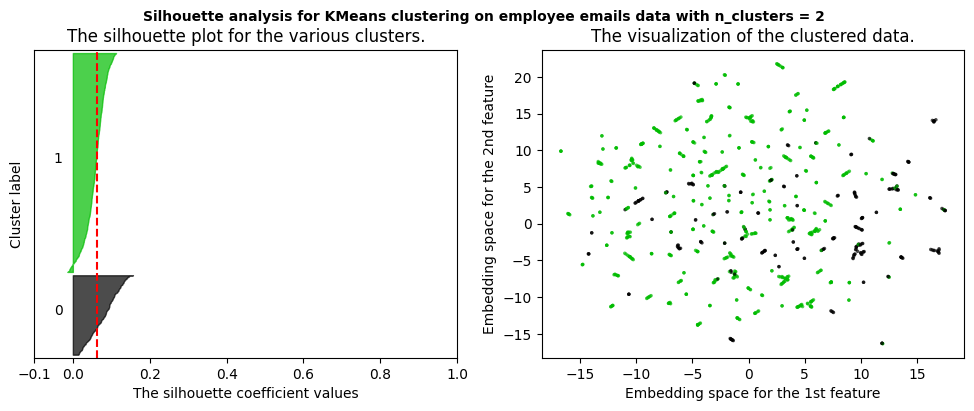

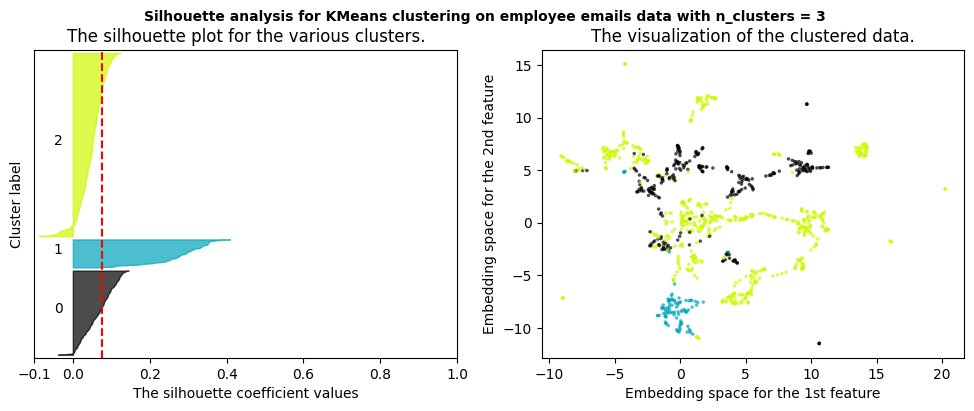

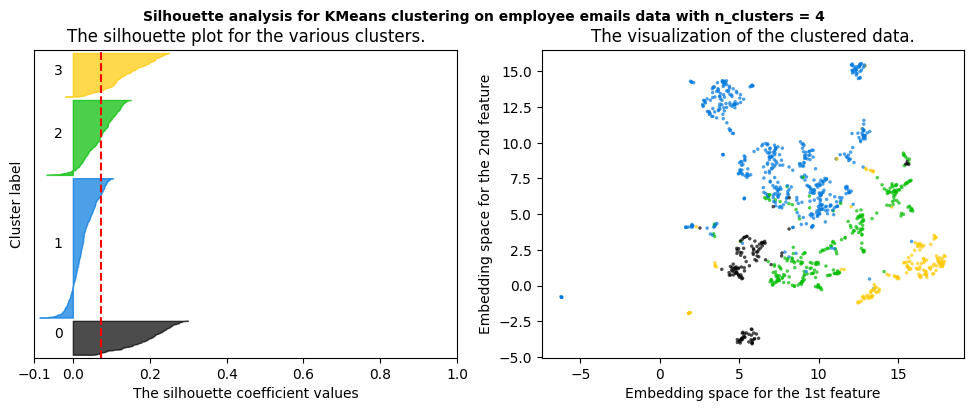

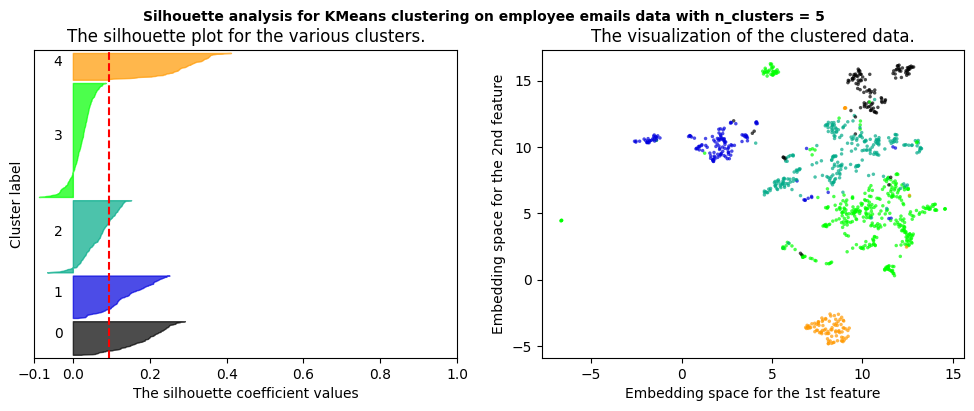

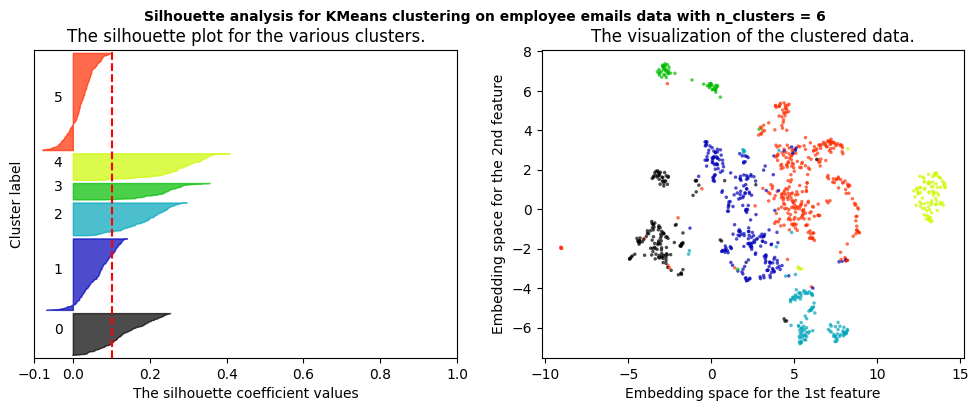

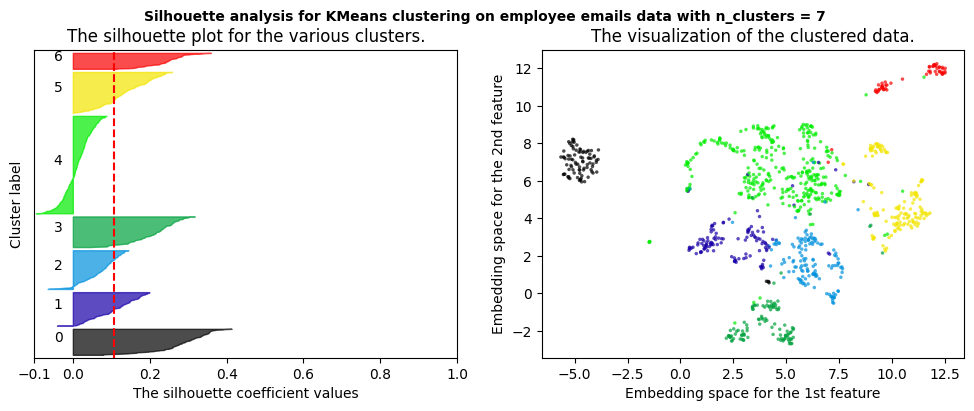

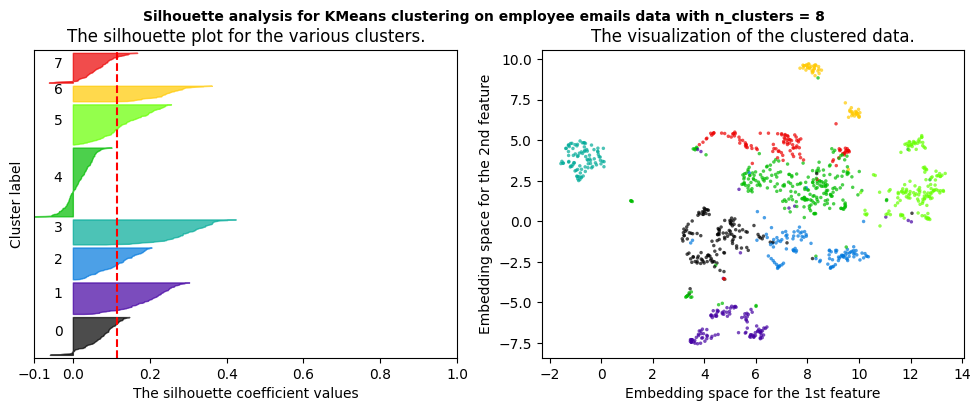

In [174]:
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# And you've already run KMeans clustering as shown in your initial code

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)

    # The silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(node_embeddings) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(node_embeddings)

    silhouette_avg = silhouette_score(node_embeddings, cluster_labels)
    print("For {} clusters, The average silhouette_score is : {:.4f}".format(n_clusters, round(silhouette_avg, 4)) )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(node_embeddings, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for K-means clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Create a UMAP embedding for visualization
    embedding = umap.UMAP(n_neighbors=n_clusters, min_dist=0.3, metric='euclidean').fit_transform(node_embeddings)
    
    # Plotting the UMAP embedding
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(embedding[:, 0], embedding[:, 1], marker=".", s=25, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Embedding space for the 1st feature")
    ax2.set_ylabel("Embedding space for the 2nd feature")

    plt.suptitle((f"Silhouette analysis for KMeans clustering on employee emails data "
                  f"with n_clusters = {n_clusters}"),
                 fontsize=10, fontweight='bold')
plt.show()


### Silhouette Analysis of Classical Methods (Louvain)

We compare the best performing classicial community detection algorithm Louvain (better than Leiden in our case-study) in Silhouette analysis agains ML (k-means). It turns out that Louvain offers a negative average silhouette score and that is why the communities are inter-mixed with each other. 

The average silhouette_score is : -0.0217


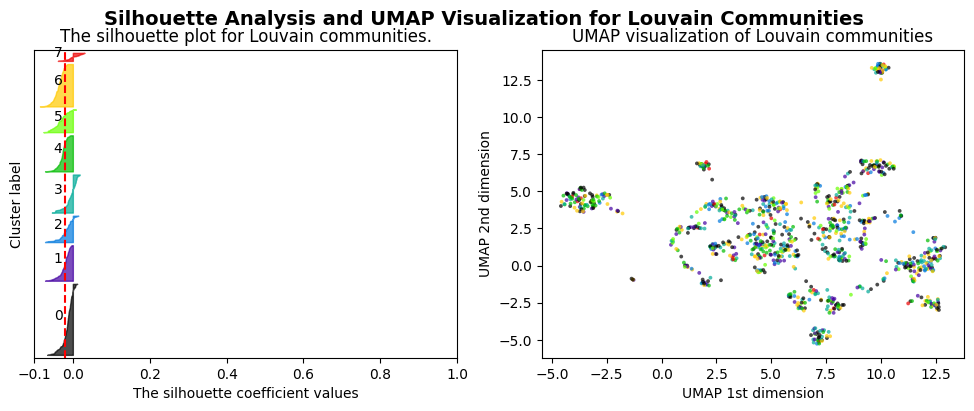

In [192]:
# Prepare the cluster labels array
node_order = list(G.nodes())  # List of nodes in the order they appear in 'node_embeddings'
cluster_labels = np.array([louvain_partition[node] for node in node_order])

# Calculate the silhouette score
silhouette_avg = silhouette_score(node_embeddings, cluster_labels)
print(f"The average silhouette_score is : {silhouette_avg:.4f}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(node_embeddings, cluster_labels)

num_communities = len(set(cluster_labels))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)

# Silhouette plot on the left side (ax1)
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(node_embeddings) + (num_communities + 1) * 10])

y_lower = 10
for i in range(num_communities):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / num_communities)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for Louvain communities.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# UMAP visualization on the right side (ax2)
umap_embedding = umap.UMAP(n_neighbors=num_communities, min_dist=0.3, metric='euclidean').fit_transform(node_embeddings)
colors = cm.nipy_spectral(cluster_labels.astype(float) / num_communities)
ax2.scatter(umap_embedding[:, 0], umap_embedding[:, 1], marker=".", s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

ax2.set_title("UMAP visualization of Louvain communities")
ax2.set_xlabel("UMAP 1st dimension")
ax2.set_ylabel("UMAP 2nd dimension")

plt.suptitle("Silhouette Analysis and UMAP Visualization for Louvain Communities", fontsize=10, fontweight='bold')
plt.show()


## Comparision of Louvain vs K-means

Thus, we could conclude from our comparison that ML approach works best for our use case (emails dataset), nevertheless we can't take a deicsion based merly on silhouette score as there are other metrics that could be further explored to make a much more roboust comparision but we've to restrict ourselves to the scope of our class.

## Influence Maximization

### Greedy approach
Let us use the greedy method to find influencer seed nodes in the current dataset

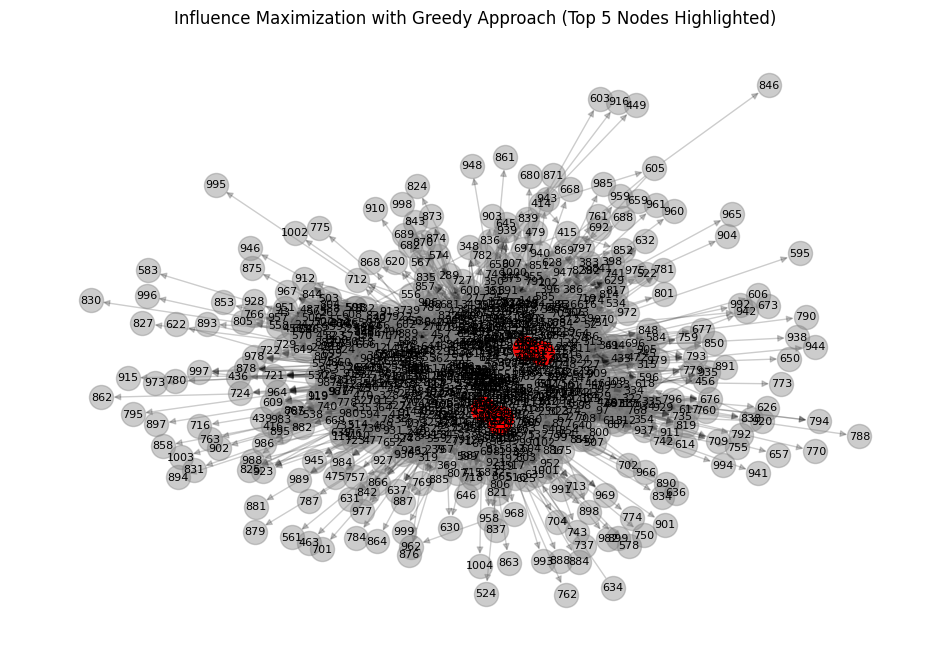

In [13]:
# Influence Maximization using Greedy Approach
def greedy_influence_maximization(G, k):
    """
    Greedy algorithm for Influence Maximization.
    G: Graph
    k: Number of nodes to select
    Returns: Set of nodes selected as initial seed set
    """
    S = set()
    for _ in range(k):
        max_gain = 0
        best_node = None
        for node in set(G.nodes) - S:
            # Estimate the influence spread of adding node to S
            # Here we use a simple heuristic for the sake of demonstration
            gain = len(set(nx.descendants(G, node)) - S)
            if gain > max_gain:
                max_gain = gain
                best_node = node
        S.add(best_node)
    return S

# Selecting top k nodes for influence maximization
k = 5
selected_nodes = greedy_influence_maximization(G, k)

# Plotting the results
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))

# Draw all nodes
nx.draw_networkx_nodes(G, pos, node_color='grey', alpha=0.4)
# Highlight selected nodes
nx.draw_networkx_nodes(G, pos, nodelist=selected_nodes, node_color='red', alpha=0.9)

nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', arrowsize=10, edge_color='black', alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title(f'Influence Maximization with Greedy Approach (Top {k} Nodes Highlighted)')
plt.axis('off')
plt.show()


In [15]:
print(f"Selected nodes: {seed_nodes}")

Selected nodes: {0, 1, 2, 3, 4}


#### Animated Visual of Infection Diffusion
As we can see from the above figure it is very hard to distinguish the seed nodes from actual.
Let us use animations to make the infection propagation more clear

In [212]:
from IPython.display import HTML

video_path = "greedy-diffusion-animation.mp4"  # Replace "video.mp4" with the actual path to your video file

video_html = f"""
<video width="640" height="480" controls>
  <source src="{video_path}" type="video/mp4">
  Your browser does not support the video tag.
</video>
"""

HTML(video_html)


Only run the following if you have installed `ffmpeg` and it takes around 20 mintues to generate video for the current dataset using CPU

In [13]:
# import matplotlib.animation as animation
# %matplotlib inline
# from IPython.display import HTML

# k = 5
# # Convert the graph to directed Graph
# diGraph = nx.to_directed(G)

# selected_nodes = greedy_influence_maximization(diGraph, k)

# # Function to simulate influence spread from a set of seed nodes
# def simulate_influence_spread(diGraph, seed_nodes, steps=5):
#     influenced_nodes = [set(seed_nodes)]
#     for _ in range(steps):
#         new_influenced = set()
#         for node in influenced_nodes[-1]:
#             for neighbor in diGraph.successors(node):
#                 if neighbor not in influenced_nodes[-1]:
#                     new_influenced.add(neighbor)
#         influenced_nodes.append(influenced_nodes[-1].union(new_influenced))
#     return influenced_nodes

# # Simulate influence spread
# seed_nodes = selected_nodes
# steps = 5
# influence_over_time = simulate_influence_spread(diGraph, seed_nodes, steps)

# # Setting up the animation
# fig, ax = plt.subplots(figsize=(12, 8))
# pos = nx.spring_layout(diGraph, seed=42)

# def update(num, diGraph, pos, influence_over_time):
#     ax.clear()
#     nx.draw_networkx_nodes(diGraph, pos, node_color='grey', alpha=0.2, ax=ax)
#     nx.draw_networkx_edges(diGraph, pos, arrows=True, arrowstyle='-|>', arrowsize=10, edge_color='black', alpha=0.05, ax=ax)
#     if num > 0:
#         nx.draw_networkx_nodes(diGraph, pos, nodelist=influence_over_time[num-1], node_color='blue', alpha=0.5, ax=ax)
#     nx.draw_networkx_nodes(diGraph, pos, nodelist=seed_nodes, node_color='red', alpha=0.9, ax=ax)
#     ax.set_title(f'Step {num}/{steps}: Influence Spread Simulation')
#     plt.axis('off')

# ani = animation.FuncAnimation(fig, update, frames=len(influence_over_time), fargs=(diGraph, pos, influence_over_time), interval=1000, repeat=True)

# plt.close()  # Prevents duplicate display
# Ensure matplotlib plots inline and set up the notebook for display


# Assuming 'ani_directed' is your animation object from the previous steps

# Convert the animation to HTML5 video and display it within the notebook
# HTML(ani.to_html5_video())



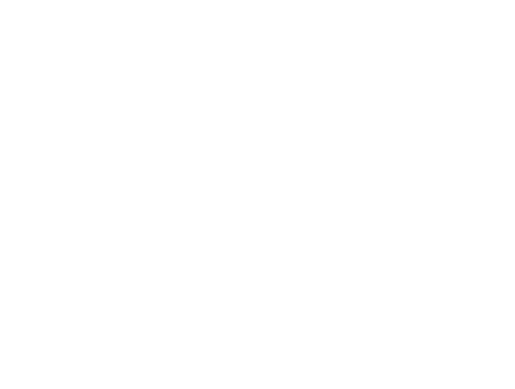

#### Results verification

We can deduce from some metrics if the choice of seed nodes by greedy approach is sound by comparing to average.
E.g. in case of average degree centrality we can say the the selected seed nodes have higher degree centrality than average but in case of betweeness centrality we can see that the node $0$ and node $1$ has comparitvely less value than average than the rest of seed nodes but it makes sense because betweeness centrality isn't the only factor that determines how influencial a node is

In [20]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

seed_degree_centrality = {node: degree_centrality[node] for node in seed_nodes}
seed_betweenness_centrality = {node: betweenness_centrality[node] for node in seed_nodes}

avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality) 

print(f"Average Degree Centrality: {avg_degree_centrality:.4f}")
# Dictionary 1: seed_degree_centrality
print("seed_degree_centrality:")
for node, value in seed_degree_centrality.items():
    print(f"{node}: {round(value, 4)}")

print(f"Average Betweenness Centrality: {avg_betweenness_centrality:.4f}")
# Dictionary 2: seed_betweenness_centrality
print("seed_betweenness_centrality:")
for node, value in seed_betweenness_centrality.items():
    print(f"{node}: {round(value, 4)}")


Average Degree Centrality: 0.0331
seed_degree_centrality:
0: 0.0426
1: 0.0508
2: 0.0944
3: 0.0701
4: 0.0954
Average Betweenness Centrality: 0.0016
seed_betweenness_centrality:
0: 0.0012
1: 0.0012
2: 0.0068
3: 0.0017
4: 0.0058
